# **O projekcie**

Projekt koncentruje się na statystycznej analizie sezonów 2019-2024 Formuły 1, obejmując punkty zdobyte przez kierowców i zespoły, wydajność zespołów w wyścigach oraz wyniki rywalizacji na torze. Analiza uwzględnia dynamikę punktacji oraz zależności między pozycjami startowymi a wynikami końcowymi. Celem projektu jest zidentyfikowanie najważniejszych czynników wpływających na wyniki sezonu, a także dostarczenie wniosków opartych na danych, które pozwolą lepiej zrozumieć rywalizację w tej dyscyplinie.

## **Wykorzystywane biblioteki**

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fastf1 as ff1
import fastf1.plotting
import statsmodels
import requests
import sklearn
from scipy import stats

# **Gromadzenie i czyszczenie danych**

Do pozyskania danych wyścigowych wykorzystano Ergast API, które oferuje otwarty dostęp do szczegółowych informacji o Formule 1, takich jak wyniki wyścigów, pozycje startowe, zdobyte punkty, czy statystyki zespołów i kierowców. API umożliwia pobieranie danych w formacie JSON, co ułatwia ich obróbkę z użyciem Python'a.

W ramach projektu zgromadzono dane obejmujące sezony od 2019 do 2024 włącznie, które zostały przechowywane w bazie SQLite.

W jednej analizie użyłem biblioteki fastf1 do analizy tempa wyścigowego. Dane zgromadzone w Ergast API nie uwzględniały pitstopów, samochodu bezpieczeństwa, flag itp., więc nie było prostego sposobu, żeby oczyścić dane o czasie okrążenia. Biblioteka fastf1 pozwoliła mi wyizolować okrążenia "szybkie" (bez żadnych zakłóceń zewnętrznych) i je przeanalizować.

Należy pamiętać, że sezon 2020 został znacznie skrócony przez pandemię COVID, od sezonu 2022 znacznie zmieniła się zasady techniczne co do aerodynamiki i silnika bolidów, co spowodowało znaczne zmiany w osiągach drużyn.

W analizie używam tylko nazw (i kolorów) zespołów z 2024 roku, nazwy (i kolory) drużyn z poprzednich lat zostały zmienione na te aktualne (np. Renault na Alpine).

Kierowcy, którzy w tym okresie zmienili drużynę, są przypisani do najaktualniejszej drużyny (np. Sebastian Vettel jest przypisany do drużyny Aston Martin, a w 2019-2020 był w Ferrari, 2021-2022 w Astonie Martinie, potem przeszedł na emeryturę). 

Funkcja ergast_retrieve pobiera dane z Ergast API dla podanego endpointu.

In [3]:
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()
    
    return response['MRData']

**Łączę się z bazą danych:**

In [4]:
db = sqlite3.connect("dataset.db")
cursor = db.cursor()

In [6]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tabele w bazie danych:")
for i in range(1, len(tables)):
    print("- " + tables[i][0])

Tabele w bazie danych:
- constructors
- constructorStandings
- qualifyingResults
- raceResults
- drivers
- driverStandings


In [7]:
rounds = [21, 17, 22, 22, 22, 24]

**Następnie wprowadzam dane z API do bazy danych.** <br>
(*Część danych nie była bezpośrednio dostępna w API, więc musiałem je wprowadzić do bazy danych z ręki 
(kolumny constructors(colorHex) oraz drivers(constructorId))*

In [9]:
constructorsJSON = ergast_retrieve(f'2024/constructors')
constructors = constructorsJSON['ConstructorTable']['Constructors']

for constructor in constructors:
    constructorId = constructor['constructorId']
    name = constructor['name']
    cursor.execute('''INSERT OR IGNORE INTO constructors (constructorId ,name, colorHex) VALUES (?, ?, "#000000")''', (constructorId, name,))

db.commit()

In [22]:
for year in range(2019, 2024):
    driversJSON = ergast_retrieve(f'{year}/drivers')
    drivers = driversJSON['DriverTable']['Drivers']
    for driver in drivers:
        firstName = driver['givenName']
        lastName = driver['familyName']
        driverId = driver['driverId']
        number = driver['permanentNumber']
        cursor.execute('''INSERT OR IGNORE INTO drivers (firstName, lastName, driverNumber, constructorID, driverId) VALUES (?, ?, ?, 0, ?)''', (firstName, lastName, number, driverId))

db.commit()

**Dla driverStandings dodałem dane precyzujące, że na początku sezonu 2019 kierowcy nie mieli punktów.**

In [ ]:
standingsJSON = ergast_retrieve(f'2019/1/driverStandings')
standings = standingsJSON['StandingsTable']['StandingsLists'][0]['DriverStandings']

for standing in standings:
        points = 0
        raceNumber = 0
        driverNumber = standing['Driver']['permanentNumber']
        cursor.execute('''INSERT INTO driverStandings (points, round, driverNumber, year) VALUES (?, ?, ?, ?)''', (points, raceNumber, driverNumber, 2019))

offset = {}
for year in range(2019, 2025):
    print()
    print("Zbieram dane z: " + year + ". Zebrane rundy:")
    if year != 2019:
        processed_data = []
        offsetJSON = ergast_retrieve(f'{year-1}/{rounds[year-2020]}/driverStandings')
        standings = offsetJSON['StandingsTable']['StandingsLists'][0]['DriverStandings']
        for standing in standings:
            points = standing['points']
            driverNumber = standing['Driver']['permanentNumber']
            if driverNumber in offset:
                offset[driverNumber] += float(points)
            else:
                offset[driverNumber] = float(points)
    for i in range(1, rounds[year-2019]+1):
        print(i, end=" ")
        standingsJSON = ergast_retrieve(f'{year}/{i}/driverStandings')
        standings = standingsJSON['StandingsTable']['StandingsLists'][0]['DriverStandings']
        for standing in standings:
            raceNumber = i
            driverNumber = standing['Driver']['permanentNumber']
            if driverNumber in offset:
                points = float(standing['points']) + float(offset[driverNumber])
            else:
                points = standing['points']
            cursor.execute('''INSERT INTO driverStandings (points, round, driverNumber, year) VALUES (?, ?, ?, ?)''', (points, raceNumber, driverNumber, year))

db.commit()

**Analogicznie dla constructorsStandings**

In [ ]:
standingsJSON = ergast_retrieve(f'2019/1/constructorStandings')
standings = standingsJSON['StandingsTable']['StandingsLists'][0]['ConstructorStandings']

for standing in standings:
    points = 0
    raceNumber = 0
    constructorId = standing['Constructor']['constructorId']
    if constructorId == 'racing_point':
        constructorId = 'aston_martin'
    elif constructorId == 'alfa':
        constructorId = 'sauber'
    elif constructorId == 'renault':
        constructorId = 'alpine'
    elif constructorId == 'toro_rosso' or constructorId == 'alphatauri':
        constructorId = 'rb'
    cursor.execute('''INSERT INTO constructorStandings (points, round, constructorId, year) VALUES (?, ?, ?, 2019)''', (points, raceNumber, constructorId,))

offset = {}
for year in range(2019, 2025):
    print()
    print("Zbieram dane z: " + year + ". Zebrane rundy:")
    if year != 2019:
        processed_data = []
        offsetJSON = ergast_retrieve(f'{year-1}/{rounds[year-2020]}/constructorStandings')
        standings = standingsJSON['StandingsTable']['StandingsLists'][0]['ConstructorStandings']
        for standing in standings:
            points = standing['points']
            constructorId = standing['Constructor']['constructorId']
            if constructorId == 'racing_point':
                constructorId = 'aston_martin'
            elif constructorId == 'alfa':
                constructorId = 'sauber'
            elif constructorId == 'renault':
                constructorId = 'alpine'
            elif constructorId == 'toro_rosso' or constructorId == 'alphatauri':
                constructorId = 'rb'
            if constructorId in offset:
                offset[constructorId] += float(points)
            else:
                offset[constructorId] = float(points)
    for i in range(1, rounds[year-2019]+1):
        print(i, end=" ")
        standingsJSON = ergast_retrieve(f'{year}/{i}/constructorStandings')
        standings = standingsJSON['StandingsTable']['StandingsLists'][0]['ConstructorStandings']
        for standing in standings:
            raceNumber = i
            constructorId = standing['Constructor']['constructorId']
            if constructorId == 'racing_point':
                constructorId = 'aston_martin'
            elif constructorId == 'alfa':
                constructorId = 'sauber'
            elif constructorId == 'renault':
                constructorId = 'alpine'
            elif constructorId == 'toro_rosso' or constructorId == 'alphatauri':
                constructorId = 'rb'
            if constructorId in offset:
                points = float(standing['points']) + float(offset[constructorId])
            else:
                points = standing['points']
            cursor.execute('''INSERT INTO constructorStandings (points, round, constructorId, year) VALUES (?, ?, ?, ?)''', (points, raceNumber, constructorId, year))

db.commit()

**Dla raceResults potrzebne było zmodyfikowanie przypadków, gdy kierowcy zaczynali z alei serwisowej, oznaczone przez API jako start z zerowej pozycji. Dla wszystkich tych przypadków pozycję startową = 20 (Start z alei serwisowej obiektywnie jest gorszy niż start z pozycji 20, ponieważ kierowcy mogą wyjechać dopiero po przejechaniu wszystkich kierowców za linie końca wyjazdu z alei serwisowej.).**

In [ ]:
for year in range(2019, 2025):
    print("Zbieram dane z: " + year + ". Zebrane rundy:")
    for i in range(1, rounds[year-2019]+1):
        print(i, end=" ")
        raceJSON = ergast_retrieve(f'{year}/{i}/results')
        results = raceJSON['RaceTable']['Races'][0]['Results']
        raceNumber = raceJSON['RaceTable']['Races'][0]['round']
        for result in results:
            driver = result['Driver']['permanentNumber']
            points = result['points']
            position = result['position']
            status = result['status']
            grid = result['grid']
            cursor.execute('''INSERT INTO raceResults (driverNumber, points, round, year,position,status,grid) VALUES (?, ?, ?, ?, ?, ?, ?)''', 
                           (driver, points, raceNumber, year, position, status, grid))
            
cursor.execute('''UPDATE raceResults SET grid = 20 WHERE grid = 0''')

db.commit()

**Zbieram dane do tabeli qualifyingResults osobno, ponieważ grid z tabeli raceResults nie zawsze jest równoznaczy pozycji kwalifikacji (kary, zmiany części itp.).**

In [ ]:
for year in range(2019, 2025):
    print()
    print("Zbieram dane z: " + year + ". Zebrane rundy:")
    for i in range(1, rounds[year-2019]+1):
        print(i, end=" ")
        qualifyingJSON = ergast_retrieve(f'{year}/{i}/qualifying')
        qualifyings = qualifyingJSON['RaceTable']['Races'][0]['QualifyingResults']
        roundNumber = i
        for qualifying in qualifyings:
            driver = qualifying['Driver']['permanentNumber']
            position = qualifying['position']
            fastestTime = qualifying['Q1']
            if 'Q2' in qualifying:
                fastestTime = max(fastestTime, qualifying['Q2'])
            if 'Q3' in qualifying:
                fastestTime = max(fastestTime, qualifying['Q3'])
            cursor.execute('''INSERT INTO qualifyingResults (driverNumber, position, round, year, fastestTime) VALUES (?, ?, ?, ?, ?)''', 
                           (driver, position, roundNumber, year, fastestTime))

db.commit()

# **Analiza eksploracyjna danych**

## **Ogólne przedstawienie danych**

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Liczba wierszy w każdej tabeli:")
for i in range(1, len(tables)):
    table_name = tables[i][0]
    cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
    row_count = cursor.fetchone()[0]
    print(f"Tabela '{table_name}': {row_count} wierszy")

Liczba wierszy w każdej tabeli:
Tabela 'constructors': 10 wierszy
Tabela 'constructorStandings': 1290 wierszy
Tabela 'qualifyingResults': 2556 wierszy
Tabela 'raceResults': 2559 wierszy
Tabela 'drivers': 36 wierszy
Tabela 'driverStandings': 2696 wierszy


**Poniżej przedstawiłem wizualizację punktów zdobytych na przestrzeni ostatnich 6 lat przez 10 najlepszych kierowców w tym okresie.**

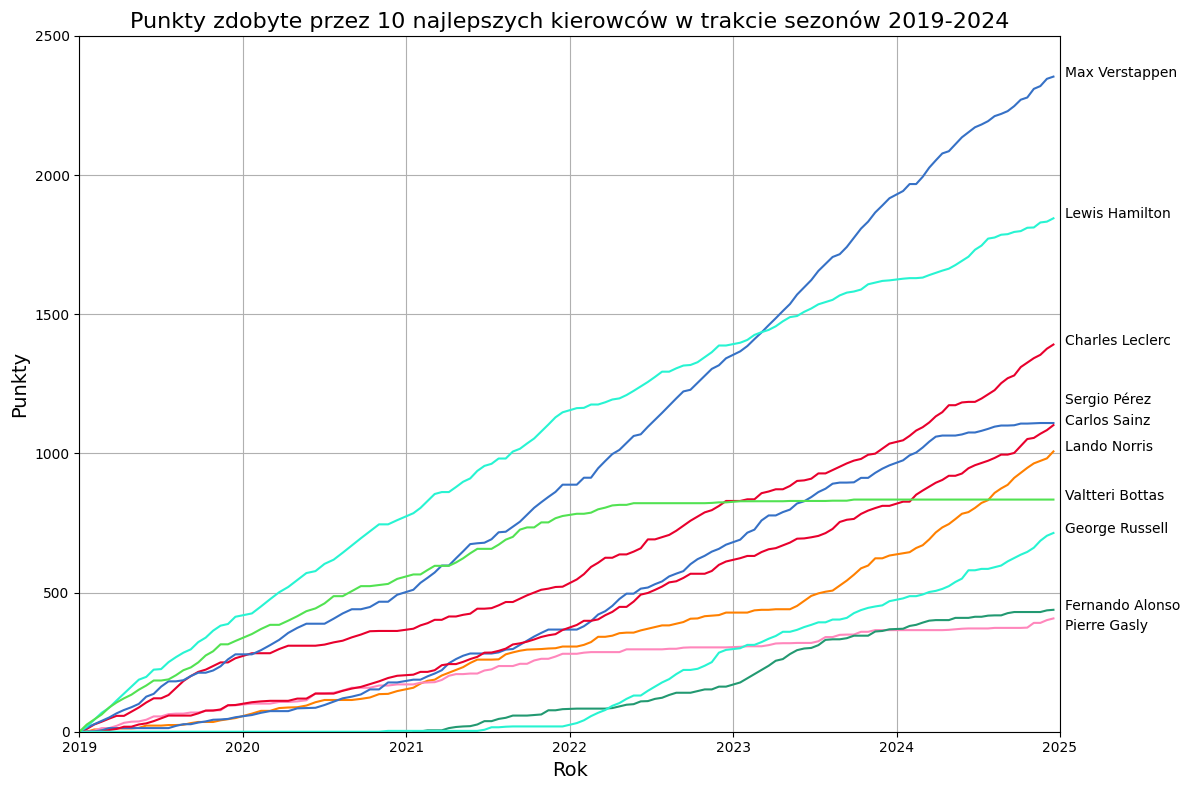

In [18]:
query = '''
SELECT colorHex, year+round*(1/((SELECT MAX(round)+1 FROM raceResults as a WHERE a.year=driverStandings.year GROUP BY year)*1.0)) as round, points, driverStandings.driverNumber, firstName || ' ' || lastName AS name
FROM driverStandings
JOIN drivers ON driverStandings.driverNumber = drivers.driverNumber
JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE driverStandings.driverNumber IN (
    SELECT driverNumber
    FROM driverStandings
    GROUP BY driverNumber
    ORDER BY MAX(points) DESC
    LIMIT 10
)
'''
df = pd.read_sql_query(query, db)

plt.figure(figsize=(12, 8))

for driver, group in df.groupby('driverNumber'):
    driver_name = group['name'].iloc[0]
    constructor_color = group['colorHex'].iloc[0]
    plt.plot(group['round'], group['points'], label=driver_name, color=constructor_color)
    last_round = group.iloc[-1]
    if driver_name == 'Sergio Pérez':
        plt.text(
            last_round['round'] + 0.07,
            last_round['points'] + 70,
            driver_name,
            fontsize=10,
            color='black'
        )
    elif driver_name == 'Pierre Gasly':
        plt.text(
            last_round['round'] + 0.07,
            last_round['points'] - 40,
            driver_name,
            fontsize=10,
            color='black'
        )
    else:
        plt.text(
            last_round['round'] + 0.07,
            last_round['points'],
            driver_name,
            fontsize=10,
            color='black'
        )

plt.xlabel('Rok', fontsize=14)
plt.xlim(2019, 2025)
plt.ylabel('Punkty', fontsize=14)
plt.ylim(0, 2500)
plt.title('Punkty zdobyte przez 10 najlepszych kierowców w trakcie sezonów 2019-2024', fontsize=16)
plt.grid(True)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

**Poniżej przedstawiłem wizualizację punktów zdobytych na przestrzeni ostatnich 6 lat przez 10 najlepszych kierowców w tym okresie.**

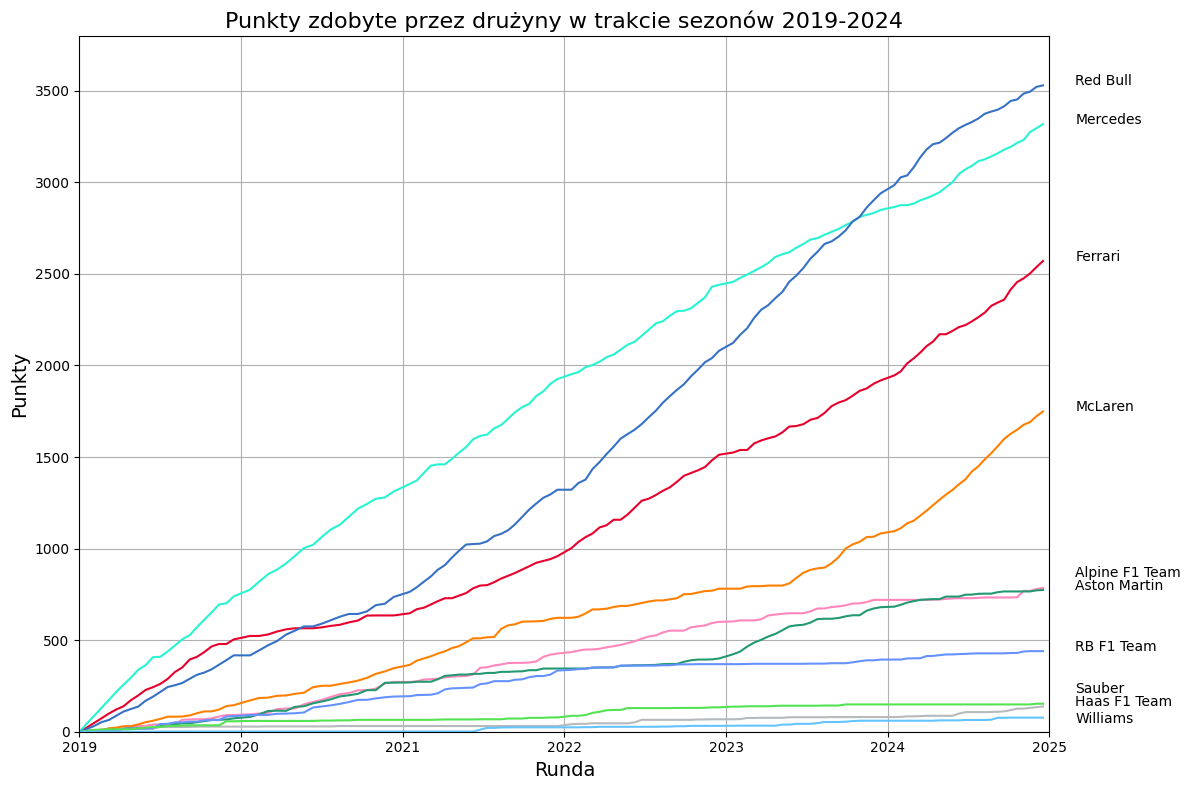

In [20]:
query = '''
SELECT colorHex, year+round*(1/((SELECT MAX(round)+1 FROM raceResults as a WHERE a.year=constructorStandings.year GROUP BY year)*1.0)) as round, points, constructorStandings.constructorId, name
FROM constructorStandings
JOIN constructors ON constructorStandings.constructorId = constructors.constructorId
ORDER BY year, round 
'''
df = pd.read_sql_query(query, db)

plt.figure(figsize=(12, 8))

for constructor, group in df.groupby('constructorId'):
    constructor_name = group['name'].iloc[0]
    constructor_color = group['colorHex'].iloc[0]
    plt.plot(group['round'], group['points'], label=constructor_name, color=constructor_color)
    
    last_round = group.iloc[-1]
    if constructor_name == 'Alpine F1 Team':
        plt.text(last_round['round'] + 0.2, last_round['points'] + 60, constructor_name)
    elif constructor_name == 'Sauber':
        plt.text(last_round['round'] + 0.2, last_round['points'] + 60, constructor_name)
    elif constructor_name == 'Williams':
        plt.text(last_round['round'] + 0.2, last_round['points'] - 30, constructor_name)
    else:
        plt.text(last_round['round'] + 0.2, last_round['points'], constructor_name)

plt.xlabel('Runda', fontsize=14)
plt.xlim(2019, 2025)
plt.ylabel('Punkty', fontsize=14)
plt.ylim(0, 3800)
plt.title('Punkty zdobyte przez drużyny w trakcie sezonów 2019-2024', fontsize=16)
plt.grid(True)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

## **Analiza eksploracyjna**

**Analiza rywalizacji Lewisa Hamiltona oraz Maxa Verstappena**

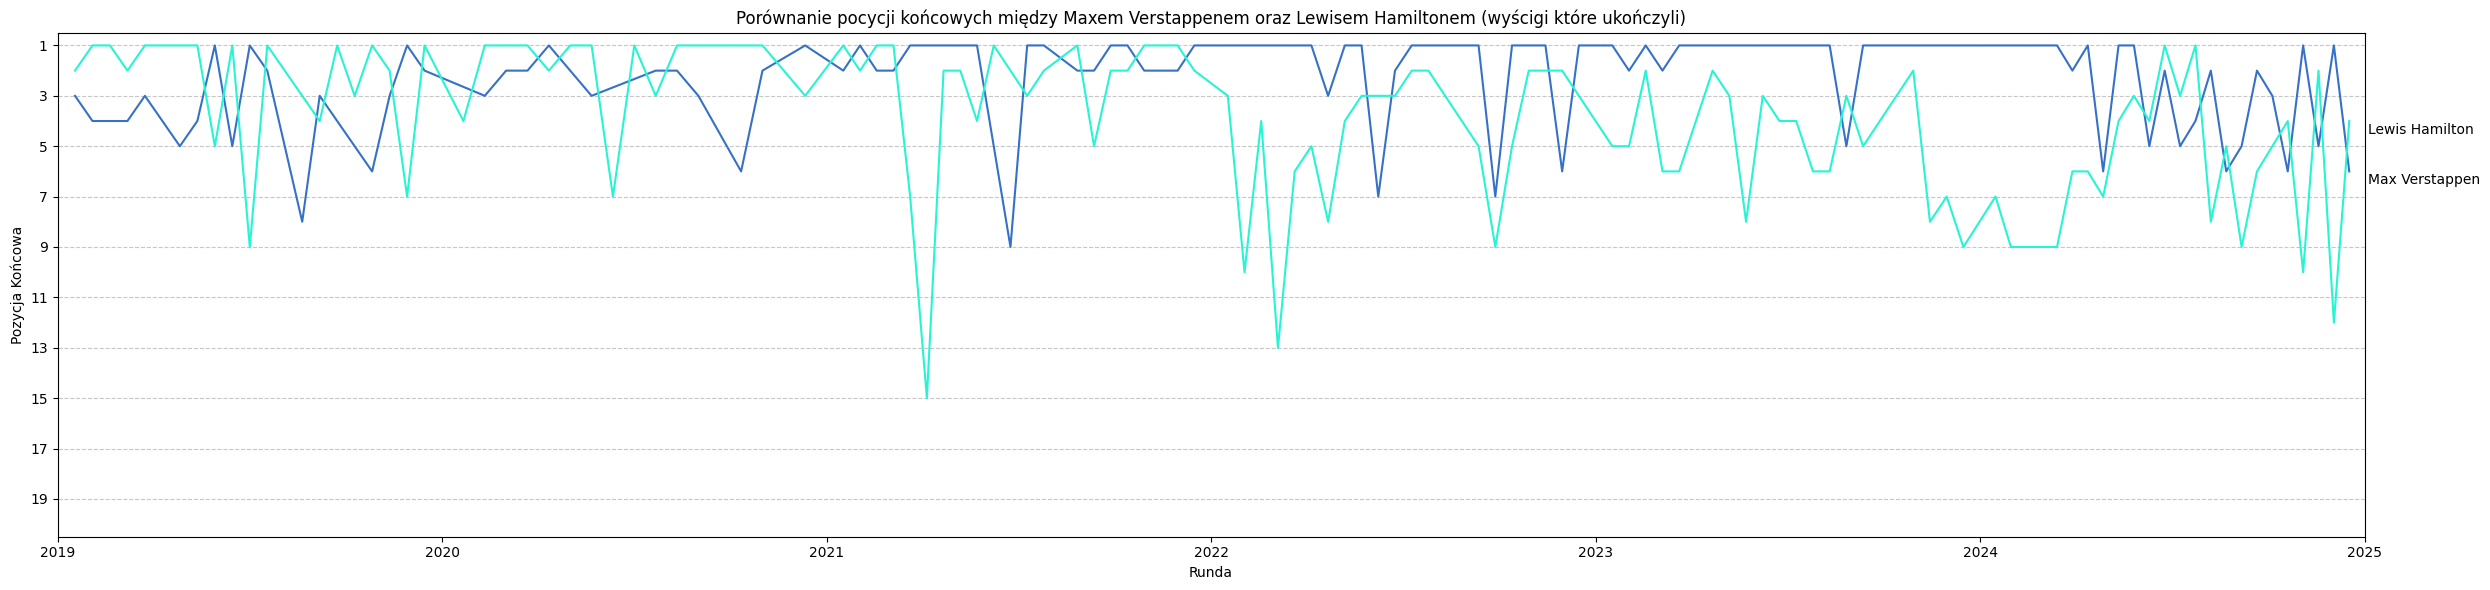

In [10]:
query = """
SELECT status, raceResults.driverNumber, raceResults.year+raceResults.round*(1/((SELECT MAX(round)+1 FROM raceResults as a WHERE a.year=raceResults.year GROUP BY year)*1.0)) as round, raceResults.position, raceResults.status, constructors.colorHex
FROM raceResults
JOIN drivers ON raceResults.driverNumber = drivers.driverNumber
JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE raceResults.driverNumber IN (33, 44) AND status IN ('Finished', '+1 Lap', '+2 Lap')
"""
df = pd.read_sql_query(query, db)

driver_44_data = df[df['driverNumber'] == 44].sort_values(by='round')
driver_33_data = df[df['driverNumber'] == 33].sort_values(by='round')

plt.figure(figsize=(25, 6))

plt.plot(driver_33_data['round'], driver_33_data['position'], 
         marker='', label='Max Verstappen', color=driver_33_data['colorHex'].iloc[0])

plt.plot(driver_44_data['round'], driver_44_data['position'], 
         marker='', label='Lewis Hamilton', color=driver_44_data['colorHex'].iloc[0])

plt.text(driver_33_data['round'].iloc[-1] + 0.05, driver_33_data['position'].iloc[-1] + 0.5, "Max Verstappen")
plt.text(driver_44_data['round'].iloc[-1] + 0.05, driver_44_data['position'].iloc[-1] + 0.5, "Lewis Hamilton")

plt.xlabel('Runda')
plt.xlim(2019, 2025)
plt.ylabel('Pozycja Końcowa')
plt.ylim(0.5, 20.5)
plt.title('Porównanie pocycji końcowych między Maxem Verstappenem oraz Lewisem Hamiltonem (wyścigi które ukończyli)')
plt.legend()
plt.gca().invert_yaxis()
plt.yticks(range(1, 21, 2))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

**Zliczenie wszystkich przypadków nie ukończenia wyścigu dla 20 najczęściej rywalizujących kierowców.**

In [17]:
query = """
SELECT 'car_fault' as fault_type, firstName || ' ' || lastName AS name, raceResults.year, raceResults.position, raceResults.status, constructors.colorHex
FROM raceResults
JOIN drivers ON raceResults.driverNumber = drivers.driverNumber
JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE status IN ('Brakes', 'Electronics', 'Engine', 'Fuel leak', 'Fuel pressure', 'Hydraulics', 'Power Unit') AND
drivers.driverNumber IN (
    SELECT driverNumber
    FROM raceResults
    GROUP BY driverNumber
    ORDER BY COUNT(*) DESC
    LIMIT 20
)
UNION
SELECT 'driver_fault' as fault_type, firstName || ' ' || lastName AS name, raceResults.year, raceResults.position, raceResults.status, constructors.colorHex
FROM raceResults
JOIN drivers ON raceResults.driverNumber = drivers.driverNumber
JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE status IN ('Spun off', 'Collision damage', 'Collision', 'Accident') AND
drivers.driverNumber IN (
    SELECT driverNumber
    FROM raceResults
    GROUP BY driverNumber
    ORDER BY COUNT(*) DESC
    LIMIT 20
);
"""
df = pd.read_sql_query(query, db)

result = df.groupby(['name', 'fault_type']).size().unstack(fill_value=0)
result['total_dnfs'] = result.sum(axis=1)
result['average_driver_fault'] = result['driver_fault'] / result['total_dnfs']

print(result)

fault_type        car_fault  driver_fault  total_dnfs  average_driver_fault
name                                                                       
Alexander Albon           4            10          14              0.714286
Carlos Sainz              4            10          14              0.714286
Charles Leclerc           5             9          14              0.642857
Daniel Ricciardo          0             4           4              1.000000
Esteban Ocon              2             6           8              0.750000
Fernando Alonso           4             1           5              0.200000
George Russell            5             7          12              0.583333
Guanyu Zhou               2             3           5              0.600000
Kevin Magnussen           6            11          17              0.647059
Lance Stroll              4            12          16              0.750000
Lando Norris              2             5           7              0.714286
Lewis Hamilt

**Analiza wydajności kierowców w wyścigach pod względem punktów**

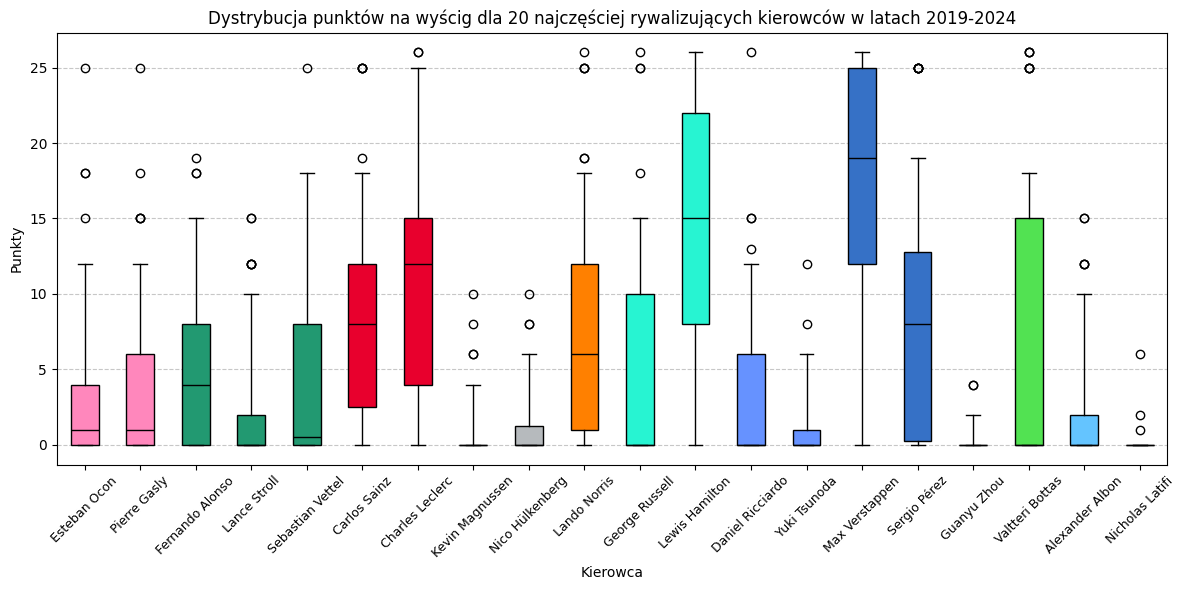

Podsumowanie punktów dla kierowców:
                 count       mean       std  min    25%   50%    75%   max
driverName                                                                
Charles Leclerc  128.0  10.343750  7.214855  0.0   4.00  12.0  15.00  26.0
Lando Norris     128.0   7.421875  6.813152  0.0   1.00   6.0  12.00  26.0
Max Verstappen   128.0  17.519531  8.664663  0.0  12.00  19.0  25.00  26.0
Sergio Pérez     126.0   8.380952  7.314487  0.0   0.25   8.0  12.75  25.0


In [159]:
query = """
SELECT
    points,
    drivers.driverNumber,
    colorHex,
    firstName || ' ' || lastName AS driverName,
    drivers.constructorId
FROM raceResults
JOIN drivers ON drivers.driverNumber = raceResults.driverNumber
JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE drivers.driverNumber IN (
    SELECT driverNumber
    FROM raceResults
    GROUP BY driverNumber
    ORDER BY COUNT(*) DESC
    LIMIT 20
);
"""
df = pd.read_sql_query(query, db)

boxplot_data = [group['points'].values for _, group in df.groupby(['constructorId', 'driverName'])]
driver_names = [group['driverName'].iloc[0] for _, group in df.groupby(['constructorId', 'driverName'])]
colors = [group['colorHex'].iloc[0] for _, group in df.groupby(['constructorId', 'driverName'])]

plt.figure(figsize=(12, 6))
bp = plt.boxplot(boxplot_data,
                 whis = [5,95],
                 patch_artist=True, 
                 tick_labels=driver_names, 
                 showfliers=True, 
                 medianprops=dict(color='black'))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Kierowca')
plt.ylabel('Punkty')
plt.title('Dystrybucja punktów na wyścig dla 20 najczęściej rywalizujących kierowców w latach 2019-2024')
plt.xticks(rotation=45, fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Podsumowanie punktów dla kierowców:")

example = df[df['driverName'].isin(['Max Verstappen', 'Lando Norris', 'Charles Leclerc', 'Sergio Pérez'])]

print(example.groupby('driverName')['points'].describe())

**Analiza wydajności kierowców w kwalifikacjach**

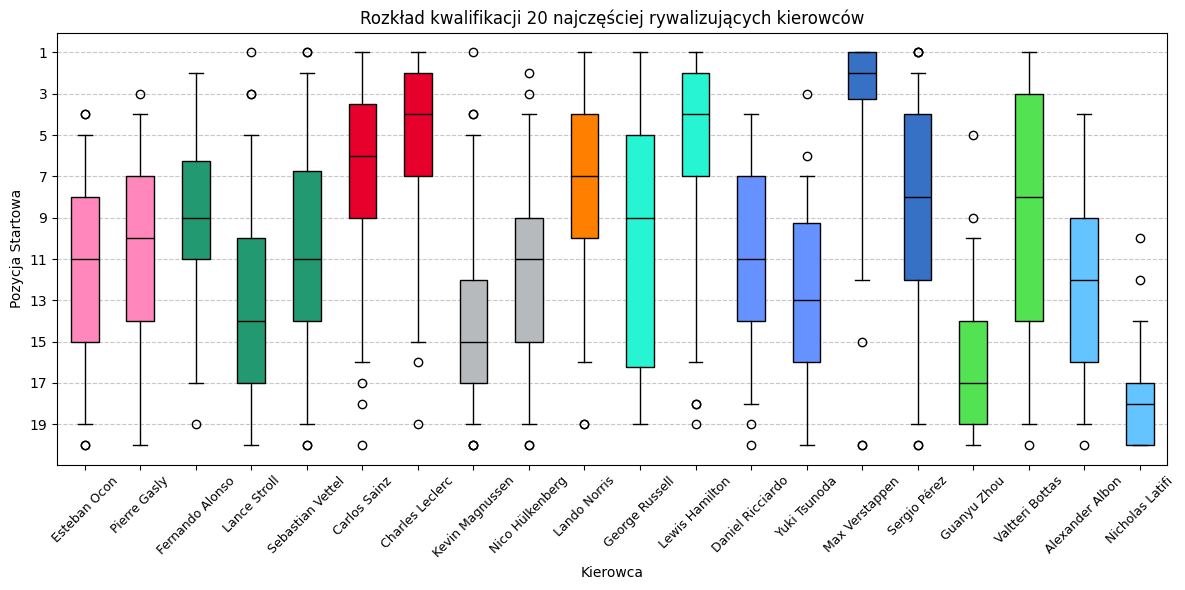

Podsumowanie kwalifikacji dla kierowców:
                 count      mean       std  min  25%  50%    75%   max
driverName                                                            
Charles Leclerc  128.0  5.179688  3.955328  1.0  2.0  4.0   7.00  19.0
Lando Norris     128.0  7.218750  4.044901  1.0  4.0  7.0  10.00  19.0
Max Verstappen   128.0  3.156250  3.239611  1.0  1.0  2.0   3.25  20.0
Sergio Pérez     126.0  8.420635  5.163492  1.0  4.0  8.0  12.00  20.0


In [152]:
query = """
SELECT position, drivers.driverNumber, colorHex, firstName || ' ' || lastName AS driverName, drivers.constructorId
FROM qualifyingResults
JOIN drivers ON drivers.driverNumber = qualifyingResults.driverNumber
JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE drivers.driverNumber IN (
    SELECT driverNumber
    FROM raceResults
    GROUP BY driverNumber
    ORDER BY COUNT(*) DESC
    LIMIT 20
);
"""
df = pd.read_sql_query(query, db)

boxplot_data = [group['position'].values for _, group in df.groupby(['constructorId', 'driverName'])]
driver_names = [group['driverName'].iloc[0] for _, group in df.groupby(['constructorId', 'driverName'])]
colors = [group['colorHex'].iloc[0] for _, group in df.groupby(['constructorId', 'driverName'])]

plt.figure(figsize=(12, 6))
bp = plt.boxplot(boxplot_data, 
                 whis=[2, 98],
                 patch_artist=True, 
                 tick_labels=driver_names, 
                 showfliers=True, 
                 medianprops=dict(color='black'))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.yticks(range(1, 21, 2))
plt.xlabel('Kierowca')
plt.ylabel('Pozycja Startowa')
plt.title('Rozkład kwalifikacji 20 najczęściej rywalizujących kierowców')
plt.xticks(rotation=45, fontsize=9)
plt.gca().invert_yaxis()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Podsumowanie kwalifikacji dla kierowców:")

example = df[df['driverName'].isin(['Max Verstappen', 'Lando Norris', 'Charles Leclerc', 'Sergio Pérez'])]

print(example.groupby('driverName')['position'].describe())

**Analiza Grand Prix Meksyku 2024**

In [ ]:
race = ff1.get_session(2024, "Mexico", 'R')
race.load()

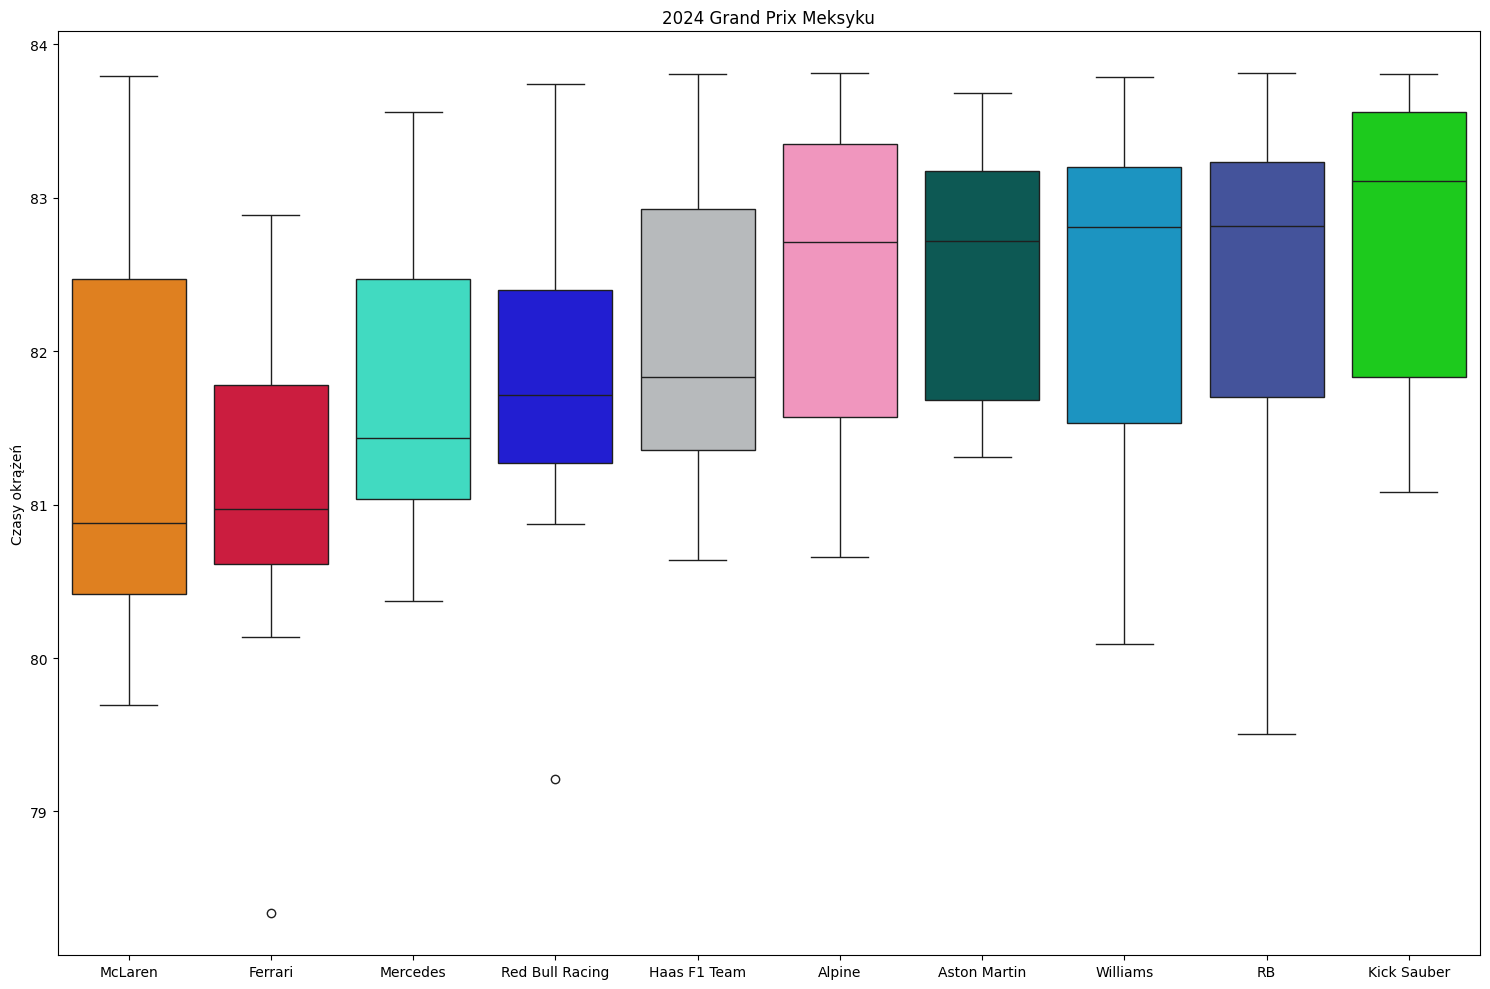

                 count       mean       std     min      25%      50%  \
Team                                                                    
Alpine           115.0  82.533922  0.907797  80.659  81.5690  82.7120   
Aston Martin      61.0  82.504295  0.746669  81.311  81.6840  82.7220   
Ferrari          124.0  81.158944  0.727162  78.336  80.6100  80.9720   
Haas F1 Team     119.0  82.040697  0.888920  80.637  81.3550  81.8320   
Kick Sauber      104.0  82.758327  0.900550  81.085  81.8320  83.1120   
McLaren          119.0  81.396134  1.144547  79.691  80.4190  80.8810   
Mercedes         125.0  81.712920  0.824893  80.371  81.0360  81.4360   
RB                55.0  82.516782  0.906808  79.502  81.6990  82.8150   
Red Bull Racing  114.0  81.924421  0.806680  79.209  81.2705  81.7120   
Williams          56.0  82.449821  1.012770  80.090  81.5345  82.8085   

                      75%     max  
Team                               
Alpine           83.35450  83.812  
Aston Martin   

In [21]:
laps = race.laps.pick_quicklaps()
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)

team_palette = {team: fastf1.plotting.get_team_color(team, session=race)
                for team in team_order}

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette
)

plt.title("2024 Grand Prix Meksyku")
plt.grid(visible=False)
ax.set(xlabel=None, ylabel="Czasy okrążeń")
plt.tight_layout()
plt.show()


print(transformed_laps.groupby('Team')['LapTime (s)'].describe())

## **Testy statystyczne**

**T-Test liczby punktów w wyścigach między zespołami McLaren i Mercedes**

In [8]:
query = """
SELECT round, drivers.constructorId as team, SUM(points) as points
FROM raceResults
JOIN drivers ON raceResults.driverNumber = drivers.driverNumber
LEFT OUTER JOIN constructors ON drivers.constructorId = constructors.constructorId
group by round, drivers.constructorId
"""
data = pd.read_sql(query, db)

team_a_results = data[data['team'] == 'mclaren']['points']
team_b_results = data[data['team'] == 'mercedes']['points']

t_stat, p_value = stats.ttest_ind(team_a_results, team_b_results)

print(f'H₀ (hipoteza zerowa): Średnia liczba punktów zespołu McLaren jest równa średniej liczbie punktów zespołu Mercedes.')
print(f'H₁ (hipoteza alternatywna): Średnie liczby punktów zespołów McLaren i Mercedes różnią się.')

print(f'T-statystyka: {t_stat}')
print(f'Wartość p: {p_value}')

print(f'p<0.05 => Odrzucam H0. Średnie liczby punktów zespołów McLaren i Mercedes różnią się.')
print(f'T-statystyka<0 => Średnia liczba punktów zespołu McLaren jest niższa niż średnia liczba punktów zespołu Mercedes.')

H₀ (hipoteza zerowa): Średnia liczba punktów zespołu McLaren jest równa średniej liczbie punktów zespołu Mercedes.
H₁ (hipoteza alternatywna): Średnie liczby punktów zespołów McLaren i Mercedes różnią się.
T-statystyka: -6.4344330156716
Wartość p: 6.44686432765855e-08
p<0.05 => Odrzucam H0. Średnie liczby punktów zespołów McLaren i Mercedes różnią się.
T-statystyka<0 => Średnia liczba punktów zespołu McLaren jest niższa niż średnia liczba punktów zespołu Mercedes.


**T-Test liczby punktów w wyścigach między kierowcami Red Bulla Maxem Verstappenem i Sergio Perezem**

In [23]:
query = """
SELECT round, driverId, points
FROM raceResults
JOIN drivers ON raceResults.driverNumber = drivers.driverNumber
LEFT OUTER JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE year BETWEEN 2021 AND 2024
"""
data = pd.read_sql(query, db)

team_a_results = data[data['driverId'] == 'max_verstappen']['points']
team_b_results = data[data['driverId'] == 'perez']['points']

t_stat, p_value = stats.ttest_ind(team_a_results, team_b_results)

print(f'H₀ (hipoteza zerowa): Średnia liczba punktów Sergio Pereza jest równa średniej liczbie punktów Maxa Verstappena.')
print(f'H₁ (hipoteza alternatywna): Średnie liczby punktów Sergio Pereza i Maxa Verstappena różnią się.')

print(f'T-statystyka: {t_stat}')
print(f'Wartość p: {p_value}')

print(f'p<0.05 => Odrzucam H0. Średnie liczby punktów Sergio Pereza i Maxa Verstappena różnią się.')
print(f'T-statystyka>0 => Średnia liczba punktów Sergio Pereza jest niższa niż średnia liczba punktów Maxa Verstappena.')

H₀ (hipoteza zerowa): Średnia liczba punktów Sergio Pereza jest równa średniej liczbie punktów Maxa Verstappena.
H₁ (hipoteza alternatywna): Średnie liczby punktów Sergio Pereza i Maxa Verstappena różnią się.
T-statystyka: 8.276264210798482
Wartość p: 2.913033642054163e-14
p<0.05 => Odrzucam H0. Średnie liczby punktów Sergio Pereza i Maxa Verstappena różnią się.
T-statystyka>0 => Średnia liczba punktów Sergio Pereza jest niższa niż średnia liczba punktów Maxa Verstappena.


**Test ANOVA punktów na wyścig między 4 najlepszymi zespołami.**

In [10]:
print("Hipoteza zerowa (H₀): Średnie wyniki wszystkich zespołów są równe.")
print("Hipoteza alternatywna (H₁): Przynajmniej jeden zespół ma inny średni wynik.")

query = """
SELECT round, drivers.constructorId, SUM(points) as points
FROM raceResults
JOIN drivers ON raceResults.driverNumber = drivers.driverNumber
LEFT OUTER JOIN constructors ON drivers.constructorId = constructors.constructorId
WHERE drivers.constructorId IN ('ferrari', 'mercedes', 'red_bull')
group by round, drivers.constructorId
"""
data = pd.read_sql(query, db)

print(data.head())

red_bull_points = data[data['constructorId'] == 'red_bull']['points']
ferrari_points = data[data['constructorId'] == 'ferrari']['points']
mercedes_points = data[data['constructorId'] == 'mercedes']['points']

f_statistic, p_value = stats.f_oneway(red_bull_points, ferrari_points, mercedes_points)

print(f"Statystyka F: {f_statistic}")
print(f"Wartość p: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Odrzucamy hipotezę zerową: Istnieją istotne różnice między zespołami.")
else:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej: Brak istotnych różnic między zespołami.")

Hipoteza zerowa (H₀): Średnie wyniki wszystkich zespołów są równe.
Hipoteza alternatywna (H₁): Przynajmniej jeden zespół ma inny średni wynik.
   round constructorId  points
0      1       ferrari   133.0
1      1      mercedes   114.0
2      1      red_bull   138.0
3      2       ferrari   105.0
4      2      mercedes   112.0
Statystyka F: 9.076646323102544
Wartość p: 0.000316593906688837
Odrzucamy hipotezę zerową: Istnieją istotne różnice między zespołami.


## **Analiza regresyjna**

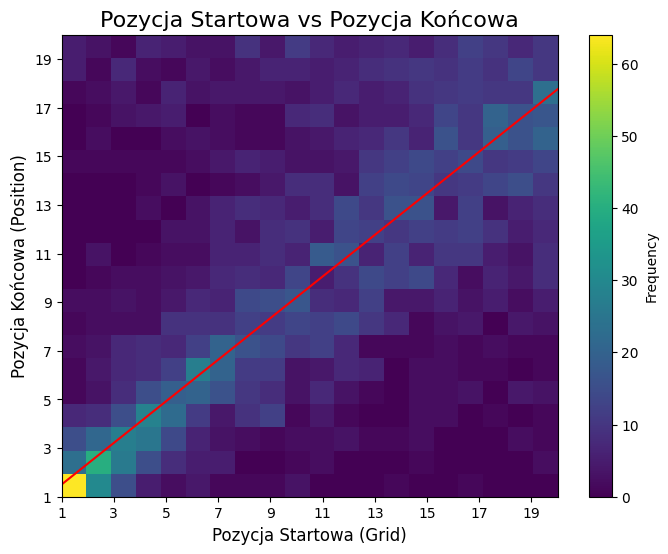

R^2 dla regresji to: 0.31013856967514564
p-value dla regresji to: 3.421341055050447e-51

position
1     0.500000
2     0.179688
3     0.117188
4     0.054688
5     0.007812
6     0.007812
7     0.015625
8     0.007812
9     0.015625
15    0.007812
18    0.007812
19    0.039062
20    0.039062
Name: count, dtype: float64

position
1     0.236220
2     0.314961
3     0.165354
4     0.062992
5     0.023622
6     0.031496
7     0.023622
8     0.015748
9     0.015748
10    0.007874
11    0.023622
15    0.007874
16    0.015748
17    0.007874
18    0.015748
19    0.007874
20    0.023622
Name: count, dtype: float64

Przewidywana pozycja końcowa dla kierowcy zaczynającego z 30 pozycji to:  27.16723727649809
Przewidywana pozycja końcowa dla kierowcy zaczynającego z 38 pozycji to:  34.01183388356424


In [15]:
from scipy.stats import linregress

query = """
SELECT grid, position
FROM raceResults
WHERE grid IS NOT NULL AND position IS NOT NULL;
"""
df = pd.read_sql(query, db)

x = df['grid']
y = df['position']

fixed_point_x = 1
fixed_point_y = 1.5
slope = ((y - fixed_point_y) * (x - fixed_point_x)).sum() / ((x - fixed_point_x) ** 2).sum()

def constrained_line(x, slope, fixed_point_x, fixed_point_y):
    return slope * (x - fixed_point_x) + fixed_point_y

x_range = np.linspace(x.min(), x.max(), 100)
y_range = constrained_line(x_range, slope, fixed_point_x, fixed_point_y)

plt.figure(figsize=(8, 6))
plt.hist2d(x, y, bins=20, range=[[1, 20], [1, 20]], cmap='viridis')
plt.plot(x_range, y_range, color='red', label=f'Constrained Regression (slope={slope:.2f})')

plt.colorbar(label='Frequency')
plt.xlabel('X')
plt.ylabel('Y')
plt.xticks(range(1, 21, 2))
plt.yticks(range(1, 21, 2))
plt.title('Pozycja Startowa vs Pozycja Końcowa', fontsize=16)
plt.xlabel('Pozycja Startowa (Grid)', fontsize=12)
plt.ylabel('Pozycja Końcowa (Position)', fontsize=12)
plt.show()

predicted = slope * (df['grid'] - 1) + 1.5
ss_total = ((df['position'] - df['position'].mean()) ** 2).sum()
ss_residual = ((df['position'] - predicted) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
residuals = df['position'] - predicted
_, _, _, p_value, _ = linregress(df['grid'], residuals)

print("R^2 dla regresji to: " + r_squared.astype(str))
print("p-value dla regresji to: " + p_value.astype(str))
print()
grid_1_results = df[df['grid'] == 1]
position_counts = grid_1_results['position'].value_counts()
position_probabilities = position_counts / position_counts.sum()
print(position_probabilities.sort_index())
print()
grid_2_results = df[df['grid'] == 2]
position_counts = grid_2_results['position'].value_counts()
position_probabilities = position_counts / position_counts.sum()
print(position_probabilities.sort_index())
print()
print("Przewidywana pozycja końcowa dla kierowcy zaczynającego z 30 pozycji to: ", (slope*30+fixed_point_y))
print("Przewidywana pozycja końcowa dla kierowcy zaczynającego z 38 pozycji to: ", (slope*38+fixed_point_y))

# **Wnioski**

## **Wpływ pozycji w kwalifikacjach**

Analiza statystyczna potwierdziła, że pozycja startowa ma istotny wpływ na wynik kierowcy w wyścigu. Lepsze wyniki w kwalifikacjach znacząco zwiększają szansę na wysokie miejsce na mecie, co jest zgodne z charakterystyką Formuły 1, gdzie trudność w wyprzedzaniu oraz strategia wyścigowa silnie zależą od pozycji początkowej.

- Kierowcy startujący z pierwszego rzędu (pozycje 1–2) częściej osiągają miejsca na podium. (Aż 79,7% z 1 miejsca i 71,6% z miejsca 2)

## **Wpływ zespołu**

Wyniki kierowców były w dużej mierze zależne od ich zespołów, co wskazuje na kluczową rolę technologii, strategii wyścigowej oraz wydajności samochodu/
Dominacja zespołów takich jak Mercedes i Red Bull była szczególnie widoczna w okresie 2019-2024, co potwierdzają zarówno liczba wygranych wyścigów, jak i miejsc na podium.
Zmiany zespołów z lepszych na gorsze i na odwrót bardzo odbijają się na wynikach kierowców:
- Przejście Valtterego Bottasa z Mercedesa do Saubera w 2022 roku spowodowała spadek średniej liczby punktów na sezon z 258.3 do 19.6.

## **Indywidualna wydajność kierowców**

Poza pozycją startową i zespołem, indywidualna wydajność kierowców odegrała istotną rolę w osiąganych wynikach. Widać to było po różnicach wyników między kierowcami tego samego zespołu:
- Max Verstappen zdobywał średnio aż o 9.1 punktów więcej na wyścig niż jego kolega zespołowy Sergio Perez.

# **Podsumowanie**

Przeprowadzenie tej analizy danych umożliwiło mi pogłębienie wiedzy z zakresu statystyki i analizy danych, a także zachęciło do dalszego korzystania z języka Python i użytych bibliotek. Ich wszechstronność oraz intuicyjna obsługa sprawiają, że są doskonałym narzędziem do pracy z danymi.